In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pprint
import requests
import json
from bs4 import BeautifulSoup
import plotly.express as px
import netCDF4 as nc

In [2]:
file = './data/loneliness/England/msoa_loneliness.shp'
msoa_map = gpd.read_file(file)
msoa_map.head()

,objectid,msoa11cd,msoa11nm,msoa11nmw,st_areasha,st_lengths,loneills_2,loneills_1,geometry
0,1,E02000001,City of London 001,City of London 001,2.983633e+06,8017.914674,0.610642,#f5f5f5,"POLYGON ((532419.592 181998.305, 532746.814 18..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,2.091907e+06,7086.028359,-0.155306,#f5f5f5,"POLYGON ((548452.001 189024.718, 548235.426 18..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,2.122216e+06,7405.118745,0.326728,#f5f5f5,"POLYGON ((548954.500 189063.203, 548874.188 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,2.569470e+06,7148.814421,0.324374,#f5f5f5,"POLYGON ((551943.813 186027.672, 551670.812 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,1.111109e+06,5491.227647,0.334801,#f5f5f5,"POLYGON ((549145.624 187383.875, 549128.657 18..."


In [3]:
msoa_map['loneills_1'] = msoa_map['loneills_1'].replace(['nan'], '#ffffff')
msoa_map['loneills_2'] = msoa_map['loneills_2'].astype(float)

<AxesSubplot:>

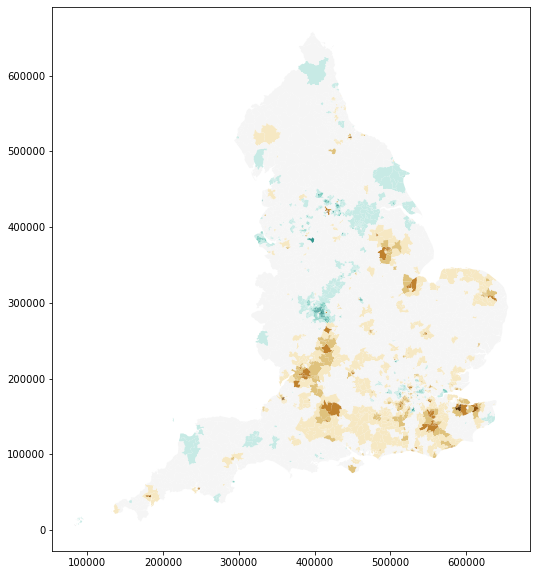

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
msoa_map.plot(ax=ax,color=[c for c in msoa_map['loneills_1']], legend=True)

In [5]:
regions = msoa_map['msoa11nm']
new_regions = []
for region in regions:
    new_regions.append(region[:-4])
new_regions = pd.Series(new_regions)

### Rainfall

In [6]:
url = 'https://www.freeflush.co.uk/blogs/freeflush-rainwater-harvesting-blog/30077441-which-is-the-rainiest-city-in-the-uk'
req = requests.get(url)
source = req.text
soup = BeautifulSoup(source, 'html.parser')

In [7]:
table_df = pd.DataFrame(columns=['City', 'Rainfall'])
table = soup.find('table', attrs={
    'class': 'tablesorter'
})
table_body = table.find('tbody')
rows = table_body.find_all('tr')
for row in rows:
    columns = row.find_all('td')
    
    if(columns != []):
        city = columns[0].text.strip()
        rainfall = columns[1].text.strip()
        
        table_df = table_df.append({'City':city, 'Rainfall':rainfall}, ignore_index=True)
    
table_df

,City,Rainfall
0,Glasgow,1124
1,St David,1138
2,Cardiff,1152
3,Newry,1019
4,Bangor,1100
...,...,...
58,Chelmsford,592
59,Derry,571
60,Ely,574
61,Cambridge,568


Reafing England shape file

In [12]:
england_shape = './data/england_cities/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.shp'
england_cities = gpd.read_file(england_shape)
england_cities = england_cities.rename(columns={'TCITY15NM' :'City'})
england_cities.head()

,OBJECTID,TCITY15CD,City,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,J01000001,Barnsley,436375,407875,-1.452250,53.56625,2.568247e+07,115099.860000,"POLYGON ((432250.004 411199.994, 432300.002 41..."
1,2,J01000002,Basildon,572525,189350,0.488409,51.57661,2.551499e+07,119299.838000,"MULTIPOLYGON (((567100.007 191450.007, 567100...."
2,3,J01000003,Basingstoke,463725,152600,-1.087930,51.26899,2.918502e+07,93900.388003,"POLYGON ((466600.000 155200.004, 466550.002 15..."
3,4,J01000004,Bath,374800,164325,-2.363450,51.37741,2.423750e+07,92099.940000,"MULTIPOLYGON (((373799.999 167549.999, 373750...."
4,5,J01000005,Bedford,505925,250450,-0.453520,52.14220,2.016749e+07,71300.186000,"MULTIPOLYGON (((505300.000 247500.003, 505250...."


<AxesSubplot:>

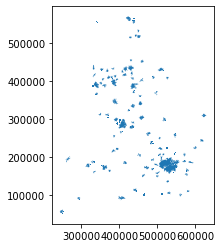

In [13]:
england_cities.plot()

In [14]:
england_file = './data/shape_england/RGN_DEC_2021_EN_BFC.shp'
england_map = gpd.read_file(england_file)

<AxesSubplot:>

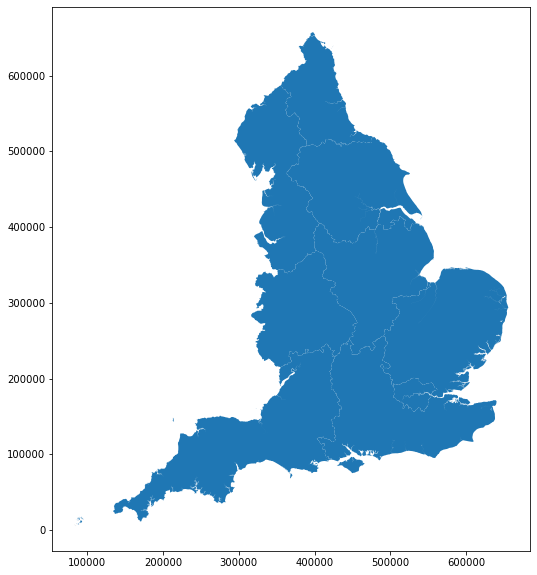

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

england_map.plot(ax=ax)

In [16]:
data = pd.merge(england_cities, table_df, on='City')
data.head(10)

,OBJECTID,TCITY15CD,City,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,Rainfall
0,4,J01000004,Bath,374800,164325,-2.363450,51.37741,2.423750e+07,92099.940000,"MULTIPOLYGON (((373799.999 167549.999, 373750....",814
1,7,J01000007,Birmingham,408850,286925,-1.871110,52.48019,2.291349e+08,271100.218100,"MULTIPOLYGON (((407750.003 276999.999, 407750....",805
2,13,J01000013,Bradford,415525,431875,-1.765870,53.78298,7.000252e+07,188999.530808,"MULTIPOLYGON (((414950.003 426099.999, 414899....",1024
3,15,J01000015,Bristol,362050,173400,-2.547600,51.45829,1.124600e+08,232400.114004,"MULTIPOLYGON (((354150.007 177549.996, 354150....",802
4,19,J01000019,Cambridge,546350,258525,0.140303,52.20553,3.762498e+07,126299.986000,"MULTIPOLYGON (((542999.998 260349.995, 543049....",568
5,20,J01000020,Cardiff,316675,180875,-3.202350,51.52062,7.138014e+07,204900.196010,"MULTIPOLYGON (((317249.986 177150.001, 317199....",1152
6,23,J01000023,Chelmsford,571625,207025,0.484100,51.73566,2.570749e+07,91000.026000,"MULTIPOLYGON (((573400.000 204799.996, 573400....",592
7,25,J01000025,Chester,340350,367350,-2.894400,53.19988,2.361748e+07,82900.062000,"MULTIPOLYGON (((339900.002 367699.996, 339950....",726
8,28,J01000028,Coventry,432700,279725,-1.520650,52.41456,7.357742e+07,238100.008000,"MULTIPOLYGON (((436249.997 283800.002, 436249....",700
9,31,J01000031,Derby,434575,334975,-1.487310,52.91111,5.869997e+07,169700.108000,"MULTIPOLYGON (((430250.000 333800.000, 430250....",709


In [17]:
data.tail()

,OBJECTID,TCITY15CD,City,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,Rainfall
32,96,J01000096,Sunderland,438625,554950,-1.39942,54.88781,3.913749e+07,135299.846000,"MULTIPOLYGON (((440949.986 555499.999, 440899....",597
33,98,J01000098,Swansea,264875,194825,-3.95394,51.63595,4.907997e+07,190900.018000,"MULTIPOLYGON (((266700.003 195300.005, 266700....",999
34,101,J01000101,Wakefield,432575,421550,-1.50820,53.68940,2.926752e+07,122899.966000,"MULTIPOLYGON (((431149.997 416999.994, 431200....",603
35,110,J01000110,Worcester,386575,255800,-2.19784,52.20027,2.423248e+07,89800.048000,"MULTIPOLYGON (((384900.003 254499.999, 384900....",606
36,112,J01000112,York,460225,452150,-1.08357,53.96195,3.369751e+07,114599.972002,"POLYGON ((458849.998 452949.994, 458849.998 45...",626


In [18]:
data['Rainfall'].isna().sum()
data['Rainfall'] = data['Rainfall'].astype(float)

<AxesSubplot:>

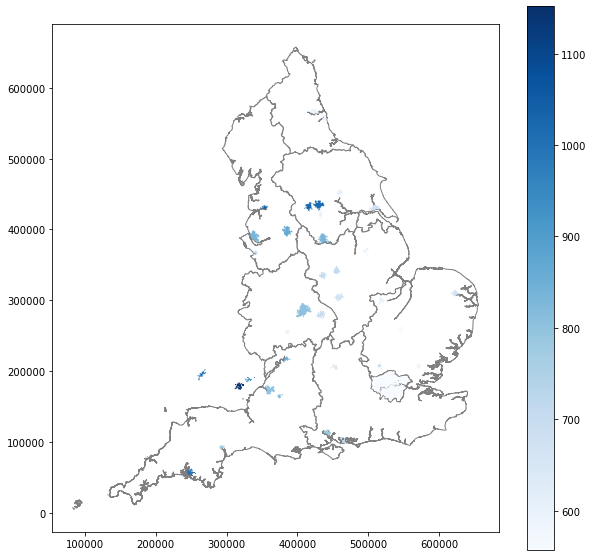

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
england_map.plot(color='white', edgecolor="grey", ax=ax)
data.plot(column='Rainfall', ax=ax, cmap='Blues',legend=True)

In [20]:
new_regions = pd.concat([new_regions,msoa_map['loneills_2']],axis=1)
new_regions = new_regions.rename(columns={0 :'City'})
new_regions

,City,loneills_2
0,City of London,0.610642
1,Barking and Dagenham,-0.155306
2,Barking and Dagenham,0.326728
3,Barking and Dagenham,0.324374
4,Barking and Dagenham,0.334801
...,...,...
6786,Greenwich,0.800393
6787,Greenwich,0.457012
6788,Liverpool,0.187870
6789,Liverpool,-0.659809


In [21]:
rain_loneliness = pd.merge(new_regions, table_df, on='City')
rain_loneliness.tail(50)

,City,loneills_2,Rainfall
1151,Norwich,1.616667,674
1152,Norwich,1.575318,674
1153,Norwich,1.234677,674
1154,Norwich,1.907026,674
1155,Norwich,2.578225,674
1156,Norwich,2.706488,674
1157,Oxford,2.372186,660
1158,Oxford,2.172818,660
1159,Oxford,2.637424,660
1160,Oxford,2.054711,660


In [22]:
print (rain_loneliness.dtypes)

City           object
loneills_2    float64
Rainfall       object
dtype: object


In [23]:
rain_loneliness['Rainfall'] = rain_loneliness['Rainfall'].astype(float)
print (rain_loneliness.dtypes)

City           object
loneills_2    float64
Rainfall      float64
dtype: object


In [24]:
rain_loneliness=rain_loneliness.groupby('City').mean()
rain_loneliness.corr()

,loneills_2,Rainfall
loneills_2,1.000000,-0.325579
Rainfall,-0.325579,1.000000


In [25]:
rain_loneliness.columns

Index(['loneills_2', 'Rainfall'], dtype='object')

In [26]:
rain_loneliness['City'] = rain_loneliness.index
rain_loneliness.columns

Index(['loneills_2', 'Rainfall', 'City'], dtype='object')

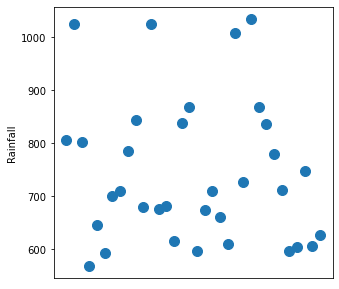

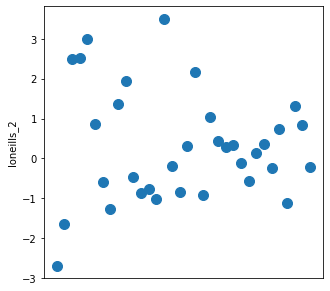

In [27]:
fig1, ax1 = plt.subplots(figsize=(5,5))
fig2, ax2 = plt.subplots(figsize=(5,5))
ax1.axes.xaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
rain_loneliness.plot.scatter(x = 'City', y = 'Rainfall', s = 100, ax=ax1);
rain_loneliness.plot.scatter(x = 'City', y = 'loneills_2', s = 100, ax=ax2);

### Temperature

In [32]:
fn = 'data/metoffice/tasmin_hadukgrid_uk_region_ann_188401-202012.nc'
ds = nc.Dataset(fn)

In [33]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    comment: annual resolution gridded climate observations
    creation_date: 2021-07-19T11:02:25
    frequency: ann
    institution: Met Office
    references: doi: 10.1002/joc.1161
    short_name: annual_mintemp
    source: HadUK-Grid_v1.0.3.0
    title: Gridded surface climate observations data for the UK
    version: v20210712
    Conventions: CF-1.7
    dimensions(sizes): time(137), region(16), bnds(2), string26(26)
    variables(dimensions): float64 tasmin(time, region), float64 time(time), float64 time_bnds(time, bnds), int32 region(region), |S1 geo_region(region, string26)
    groups: 

In [34]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4._netCDF4.Variable'>
float64 tasmin(time, region)
    standard_name: air_temperature
    long_name: Minimum air temperature
    units: degC
    description: Minimum air temperature
    label_units: C
    level: 1.5m
    plot_label: Minimum air temperature at 1.5m (C)
    cell_methods: time: minimum within days time: mean over days time: mean
    coordinates: geo_region
unlimited dimensions: 
current shape = (137, 16)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    axis: T
    bounds: time_bnds
    units: hours since 1800-01-01 00:00:00
    standard_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (137,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: 
current shape = (137, 2)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
int32

In [35]:
min_temperature = ds['tasmin'][:]
min_temperature

masked_array(
  data=[[5.280286452970278, 5.456790796785035, 3.4988685571968405, ...,
         5.65257410348458, 5.168443002883919, 5.442259125676608],
        [4.274084621847684, 4.4039367935933065, 2.4116410242179738, ...,
         4.591743368128268, 4.019754553043181, 4.086052699951934],
        [4.557874859274688, 4.648595987492595, 2.5036579434363575, ...,
         5.027035041331358, 4.171653780636056, 4.442452441483652],
        ...,
        [6.347039539239699, 6.785793145845531, 4.080240462158772, ...,
         7.078461007070184, 5.6077283681717365, 6.081188843344197],
        [6.095968188516602, 6.4772678595925415, 4.279267140744341, ...,
         7.353774593387577, 5.952239113260853, 6.192153969777953],
        [6.463962021699612, 6.986168817430493, 4.3714990324743335, ...,
         7.431980753647746, 5.774546197757247, 6.361509855625518]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, F

In [36]:
regions = ds['region'][:]
regions

masked_array(data=[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                   15, 16],
             mask=False,
       fill_value=999999)

In [37]:
geo_regions = ds['geo_region'][:]
geo_regions

masked_array(
  data=[[b'E', b'a', b's', b't', b' ', b'M', b'i', b'd', b'l', b'a',
         b'n', b'd', b's', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
         b' ', b' ', b' ', b' ', b' ', b' '],
        [b'E', b'a', b's', b't', b' ', b'o', b'f', b' ', b'E', b'n',
         b'g', b'l', b'a', b'n', b'd', b' ', b' ', b' ', b' ', b' ',
         b' ', b' ', b' ', b' ', b' ', b' '],
        [b'E', b'a', b's', b't', b' ', b'S', b'c', b'o', b't', b'l',
         b'a', b'n', b'd', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
         b' ', b' ', b' ', b' ', b' ', b' '],
        [b'L', b'o', b'n', b'd', b'o', b'n', b' ', b' ', b' ', b' ',
         b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ', b' ',
         b' ', b' ', b' ', b' ', b' ', b' '],
        [b'N', b'o', b'r', b't', b'h', b' ', b'E', b'a', b's', b't',
         b' ', b'E', b'n', b'g', b'l', b'a', b'n', b'd', b' ', b' ',
         b' ', b' ', b' ', b' ', b' ', b' '],
        [b'N', b'o', b'r', b't', b'h', b' ', b'S', b'c', b'o', b't